In [1]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [2]:
cls_cov = sacc.Sacc.load_fits('data/cls_cov.fits')
leff, cld, cov = cls_cov.get_ell_cl('cl_0e','ROSAT', 'DESY1wl__2', return_cov=True)
err = np.sqrt(np.diagonal(cov))

## Initialising defaults and tracers

In [3]:
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)

dmat = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)

nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=mdef,
                             log10M_max=15., log10M_min=10, nM=32)

# X-ray tracer
tx = rx.XrayTracer(cosmo)

zs = cls_cov.tracers['DESY1wl__2'].z
nz = cls_cov.tracers['DESY1wl__2'].nz

# gamma tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))

## Calculating the X-ray Spectrum

In [4]:
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

if os.path.isfile("data/Jtot.pck"):
    with open("data/Jtot.pck", "rb") as f:
        J_tot = pickle.load(f)
else:
    rosat_spectrum = rx.ROSATResponse('data/pspcc_gain1_256.rsp')
    J_tot = rosat_spectrum.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax)
    with open("data/Jtot.pck", "wb") as f:
        pickle.dump(J_tot, f)
if os.path.isfile("data/Jcont.pck"):
    with open("data/Jcont.pck", "rb") as f:
        J_cont = pickle.load(f)
else:
    rosat_spectrum = rx.ROSATResponse('data/pspcc_gain1_256.rsp')
    J_cont = rosat_spectrum.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax,
                                                           dolines=False, dopseudo=False)
    with open("data/Jcont.pck", "wb") as f:
        pickle.dump(J_cont, f)

## Calculating the X-ray profiles

In [5]:
# Battaglia
pressure_bg = rx.HaloProfilePressureBattaglia(mass_def=mdef, kind='n_total')
density_bg = rx.HaloProfileDensityBattaglia(mass_def=mdef, kind='n_total')
xtot_bg = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot,
                             dens=density_bg, pres=pressure_bg, fourier_approx=False)
xtot_bgc = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot, with_clumping=True,
                              dens=density_bg, pres=pressure_bg, fourier_approx=False)

# Hydrostatic Equilibirum
density_he = rx.HaloProfileDensityHE(mass_def=mdef, concentration=cM,
                                     kind='n_total')
pressure_he = rx.HaloProfilePressureHE(mass_def=mdef, concentration=cM,
                                       kind='n_total')
xtot_he = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot,
                             dens=density_he, pres=pressure_he, fourier_approx=False)
xtot_hec = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot, with_clumping=True,
                              dens=density_he, pres=pressure_he, fourier_approx=False)

# NFW
density_nfw = rx.HaloProfileDensityNFW(mass_def=mdef, concentration=cM,
                                       kind='n_total')
pressure_nfw = rx.HaloProfilePressureNFW(mass_def=mdef, concentration=cM,
                                         kind='n_total')
xtot_nfw = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot,
                              dens=density_nfw, pres=pressure_nfw,
                              fourier_approx=False, plaw_fourier=-2.7)
xtot_nfwc = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot, with_clumping=True,
                               dens=density_nfw, pres=pressure_nfw,
                               fourier_approx=False, plaw_fourier=-2.7)

[]

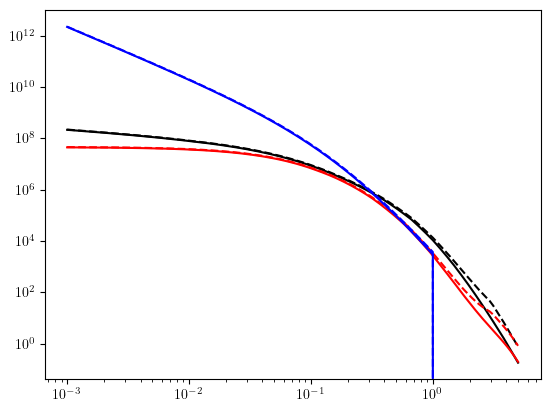

In [6]:
a = 1.
x = np.geomspace(0.001, 5, 128)
M = 1e14

r200 = mdef.get_radius(cosmo, M, a) / a
r = r200*x

x_bg = xtot_bg.real(cosmo, r, M, a)
x_he = xtot_he.real(cosmo, r, M, a)
x_nfw = xtot_nfw.real(cosmo, r, M, a)
x_bgc = xtot_bgc.real(cosmo, r, M, a)
x_hec = xtot_hec.real(cosmo, r, M, a)
x_nfwc = xtot_nfwc.real(cosmo, r, M, a)

plt.plot(r/r200, x_bg, 'k-')
plt.plot(r/r200, x_bgc, 'k--')
plt.plot(r/r200, x_he, 'r-')
plt.plot(r/r200, x_hec, 'r--')
plt.plot(r/r200, x_nfw, 'b-')
plt.plot(r/r200, x_nfwc, 'b--')
plt.loglog()

## Calculating the $P(k)$s and $C_\ell$s

In [7]:
k_arr = np.geomspace(1e-4, 100, 256)
lk_arr = np.log(k_arr)
a_arr = np.linspace(0.3,1,8)
ls = np.unique(np.geomspace(2, 3100, 128).astype(int)).astype(float)

In [8]:
pk_he = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat, prof2=xtot_he, lk_arr=lk_arr, a_arr=a_arr)
pk_bg = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat, prof2=xtot_bg, lk_arr=lk_arr, a_arr=a_arr)
pk_nfw = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat, prof2=xtot_nfw, lk_arr=lk_arr, a_arr=a_arr)
cl_bg = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_bg)
cl_he = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_he)
cl_nfw = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_nfw)

### Correcting for the smoothing

In [9]:
def pixel_FWHM(nside):
    """
    Returns the FWHM of the HEALPix pixel with nside = nside
    """
    fwhm_hp_amin =  60 * 41.7 / nside
    return np.radians(fwhm_hp_amin/60)/2.355

sigma_ROSAT = np.radians(1.8e0/60)/2.355
sigma_HEALPix = pixel_FWHM(1024)

sigma_tot_2 = sigma_ROSAT**2 + 2*sigma_HEALPix**2

def cl_smoothing_factor(ell):
    return np.exp(-0.5*sigma_tot_2*ell*(1+ell))

cl_bg *= cl_smoothing_factor(ls)
cl_he *= cl_smoothing_factor(ls)
cl_nfw *= cl_smoothing_factor(ls)

## Plots

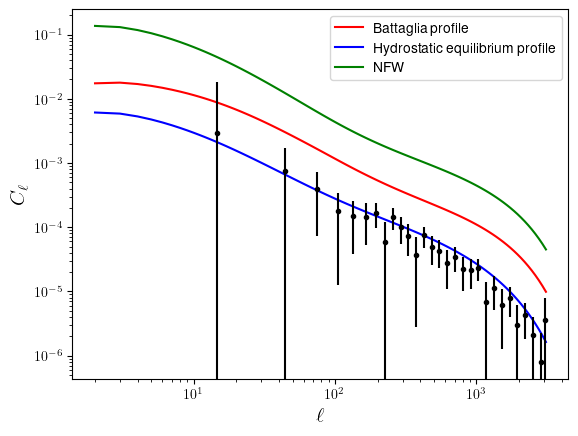

In [10]:
plt.plot(ls, cl_bg, 'r', label='Battaglia profile')
plt.plot(ls, cl_he, 'b', label='Hydrostatic equilibrium profile')
plt.plot(ls, cl_nfw, 'g', label='NFW')
plt.errorbar(leff, cld, yerr=err, fmt='k.')
plt.loglog()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)

plt.legend();

plt.savefig('Plots/Cls_Comparison.pdf');